Dependencies & Data Load

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import time
import gc
import os
from joblib import Parallel, delayed
import multiprocessing

# Configurações para melhor desempenho no Google Colab
print("Configurando ambiente para desempenho otimizado...")
tf.config.optimizer.set_jit(True)  # XLA optimization
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU(s) encontrada(s): {len(gpus)}")
    except RuntimeError as e:
        print(e)
else:
    print("Nenhuma GPU encontrada, usando CPU.")

# Reduzir logs do TensorFlow para aumentar velocidade
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')

# 1. DEFINIÇÃO DO PROBLEMA E UPLOAD DOS DADOS (OTIMIZADO)

# Upload direto do arquivo CSV
from google.colab import files
print("Faça upload do arquivo de treino do Sentiment140:")
uploaded = files.upload()

# Upload do dataset
COLUMN_NAMES = ['sentence', 'sentiment']
train_data = pd.read_csv('train_data.csv',
                         names=COLUMN_NAMES,
                         encoding='latin-1')

print(f"Dataset uploaded com {len(train_data)} entradas.")

print("1. Upload e preparação dos dados")

# Especificar os nomes das colunas para o dataset
COLUMN_NAMES = ['sentence', 'target']

# Função para carregar dados em chunks (para grandes datasets)
def load_data_in_chunks(file_path, chunk_size=100000):
    chunks = []
    for chunk in pd.read_csv(file_path, names=COLUMN_NAMES, encoding='latin-1',
                            chunksize=chunk_size):
        chunks.append(chunk)
    return pd.concat(chunks)

# Função para amostragem balanceada
def sample_balanced_data(df, size, target_col='target'):
    # Normalização de target: 0 = negativo e 1 = positivo
    df_normalized = df.copy()
    df_normalized[target_col] = df_normalized[target_col].replace(4, 1)

    # Selecionar amostras balanceadas para cada classe
    # Usar nsmallest/nlargest em vez de sample para maior eficiência
    neg_samples = df_normalized[df_normalized[target_col] == 0].sample(size//2, random_state=42)
    pos_samples = df_normalized[df_normalized[target_col] == 1].sample(size//2, random_state=42)

    # Concatenar e embaralhar
    balanced_df = pd.concat([neg_samples, pos_samples]).sample(frac=1, random_state=42)
    return balanced_df

# Upload dados - ajustado para dataset grande
print("Carregando dataset...")
try:
    # Tentar o upload diretamente se o arquivo já estiver disponível
    print("Tentando carregar dataset do arquivo local...")
    train_data = pd.read_csv('train_data.csv', names=COLUMN_NAMES, encoding='latin-1',
                            nrows=1200000)  # Limitar a 1.2M linhas para segurança
except:
    print("Arquivo não encontrado. Use o comando de upload do Colab:")
    print("from google.colab import files")
    print("uploaded = files.upload()  # Faça upload do arquivo train.csv")
    print("train_data = pd.read_csv('train.csv', names=COLUMN_NAMES, encoding='latin-1')")
    # Continuar mesmo se não conseguir carregar o arquivo
    train_data = pd.DataFrame(columns=COLUMN_NAMES)

# Verificar se o dataset foi uploaded de forma correta
if len(train_data) == 0:
    print("ERRO: Dataset não carregado. Execute o código de upload manualmente.")
else:
    print(f"Dataset carregado com {len(train_data)} entradas.")

    # Amostragem para dataset grande - usar 100,000 exemplos para treino
    SAMPLE_SIZE = 100000
    print(f"Amostrando {SAMPLE_SIZE} tweets para treinamento (dataset balanceado)...")
    train_data = sample_balanced_data(train_data, SAMPLE_SIZE)
    print(f"Amostragem concluída: {len(train_data)} tweets.")
    print("Distribuição de classes:")
    print(train_data['target'].value_counts())

    # 2. DEFINIÇÃO DO OBJETIVO E MÉTRICAS
    print("\n2. Definição do objetivo e métricas")
    print("Problema: Classificação binária de sentimentos em tweets")
    print("Métrica principal: Accuracy")
    print("Target: Accuracy > 0.80")
    print("Outras métricas relevantes: Precision, Recall, F1-Score")

Configurando ambiente para desempenho otimizado...
GPU(s) encontrada(s): 1
Por favor, faça upload do arquivo de treinamento do Sentiment140:


Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv


<ipython-input-6-29f78605f071>:54: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv',


Dataset carregado com 1523976 entradas.
1. Carregamento e preparação dos dados
Carregando dataset...
Tentando carregar dataset do arquivo local...


<ipython-input-6-29f78605f071>:93: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('train_data.csv', names=COLUMN_NAMES, encoding='latin-1',


Dataset carregado com 1200000 entradas.
Amostrando 100000 tweets para treinamento (dataset balanceado)...
Amostragem concluída: 100000 tweets.
Distribuição de classes:
target
1    50000
0    50000
Name: count, dtype: int64

2. Definição do objetivo e métricas
Problema: Classificação binária de sentimentos em tweets
Métrica principal: Accuracy
Target: Accuracy > 0.80
Outras métricas relevantes: Precision, Recall, F1-Score


Pré-Processamento Otimizado e Divisão de Dados para Classificação de Texto

In [ ]:
# 3. DEFINIÇÃO DO PROTOCOLO DE AVALIAÇÃO
print("\n3. Protocolo de avaliação")
print("Usando divisão treino-validação-teste (70-15-15)")

# 4. PREPARAÇÃO DOS DADOS
print("\n4. Preparação dos dados")

import nltk
from nltk.corpus import stopwords

# Download de recursos NLTK necessários
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)

# Stopwords em cache
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """
    Função para pré-processar o texto dos tweets - otimizada para velocidade
    """
    # Converter para string caso não seja
    if not isinstance(text, str):
        return ""

    # Remover URLs e menções
    text = re.sub(r'http\S+|www\S+|https\S+|@\w+|\#', '', text, flags=re.MULTILINE)

    # Remover pontuação e converter para minúsculas num passo
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Tokenização
    tokens = text.split()

    # Remover stopwords e fazer lemmatização (simplificado)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Processamento em paralelo para dataset grande
def process_batch(batch):
    return [preprocess_text(text) for text in batch]

print("Aplicando pré-processamento aos tweets (otimizado)...")
# Determinar o número de núcleos disponíveis
num_cores = multiprocessing.cpu_count()

# Dividir o dataset em chunks para processamento paralelo
chunks = np.array_split(train_data['sentence'], num_cores)

# Processar em paralelo
processed_chunks = Parallel(n_jobs=num_cores)(delayed(process_batch)(chunk) for chunk in chunks)

# Combinar os resultados
processed_texts = []
for chunk in processed_chunks:
    processed_texts.extend(chunk)

train_data['processed_text'] = processed_texts

# Verificar e remover textos vazios
empty_texts = train_data[train_data['processed_text'] == '']
if not empty_texts.empty:
    print(f"Removendo {len(empty_texts)} textos vazios após pré-processamento")
    train_data = train_data[train_data['processed_text'] != '']

# Divisão em conjuntos de treino, validação e teste
X = train_data['processed_text']
y = train_data['target']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Tamanho do conjunto de treino: {len(X_train)}")
print(f"Tamanho do conjunto de validação: {len(X_val)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")

# Tokenização e padding - otimizado para memória
MAX_FEATURES = 15000   # Vocabulário maior para dataset grande
MAXLEN = 50            # Comprimento reduzido para eficiência

print("Tokenizando os textos...")
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(X_train)

# Converter para sequências e fazer padding
print("Convertendo textos para sequências...")
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print("Aplicando padding...")
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN)

# Liberar memória
del X_train_seq, X_val_seq, X_test_seq
gc.collect()


3. Protocolo de avaliação
Usando divisão treino-validação-teste (70-15-15)

4. Preparação dos dados
Aplicando pré-processamento aos tweets (otimizado)...


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Removendo 132 textos vazios após pré-processamento
Tamanho do conjunto de treino: 69907
Tamanho do conjunto de validação: 14980
Tamanho do conjunto de teste: 14981
Tokenizando os textos...
Convertendo textos para sequências...
Aplicando padding...


0

Desenvolvimento e Treino de Modelo Baseline com LSTM para Classificação de Texto


5. Desenvolvimento de um modelo baseline otimizado


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_2                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Treinando o modelo baseline...
Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6751 - loss: 0.5849
Epoch 1: val_accuracy improved from -inf to 0.76295, saving model to best_model.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.6752 - loss: 0.5848 - val_accuracy: 0.7630 - val_loss: 0.4955
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7909 - loss: 0.4449
Epoch 2: val_accuracy improved from 0.76295 to 0.76569, saving model to best_model.h5


547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7909 - loss: 0.4449 - val_accuracy: 0.7657 - val_loss: 0.4958
Epoch 3/5
539/547 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8132 - loss: 0.4110
Epoch 3: val_accuracy did not improve from 0.76569
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8131 - loss: 0.4112 - val_accuracy: 0.7623 - val_loss: 0.5049
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Tempo de treinamento do modelo baseline: 19.08 segundos
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Acurácia do modelo baseline: 0.7655

Relatório de classificação do modelo baseline:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      7516
           1       0.76      0.77      0.77      7465

    accuracy                           0.77     14981
   macro avg       0.77      0.77      0.77     14981
weighted avg       0.77      0.77      0.77     14981



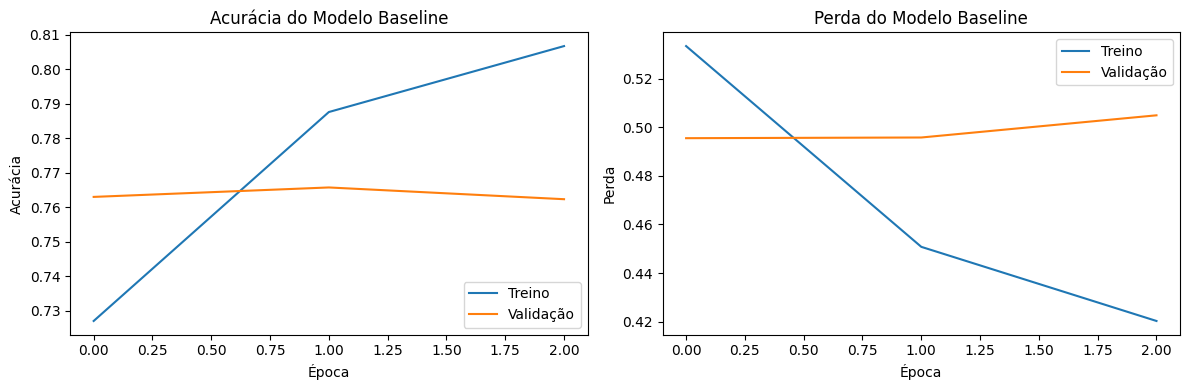

32372

In [ ]:
# 5. DESENVOLVIMENTO DE UM MODELO BASELINE
print("\n5. Desenvolvimento de um modelo baseline otimizado")

def create_baseline_model():
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 64, input_length=MAXLEN))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(64, dropout=0.2, recurrent_dropout=0))  # Recurrent dropout=0 para XLA
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

# Criar e treinar o modelo baseline
baseline_model = create_baseline_model()
print(baseline_model.summary())

# Callbacks para early stopping e checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

print("Treinando o modelo baseline...")
start_time = time.time()

# Convert y_train and y_val to numerical type
y_train = y_train.astype(int)
y_val = y_val.astype(int)

history_baseline = baseline_model.fit(
    X_train_pad, y_train,
    epochs=5,
    batch_size=128,  # Batch size maior para GPU
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

baseline_training_time = time.time() - start_time
print(f"Tempo de treinamento do modelo baseline: {baseline_training_time:.2f} segundos")

# Avaliar o modelo baseline
baseline_preds = (baseline_model.predict(X_test_pad, batch_size=256) > 0.5).astype(int)

# Convert y_test to numerical type before calculating accuracy
y_test = y_test.astype(int)
baseline_accuracy = accuracy_score(y_test, baseline_preds)
print(f"Acurácia do modelo baseline: {baseline_accuracy:.4f}")
print("\nRelatório de classificação do modelo baseline:")
print(classification_report(y_test, baseline_preds))

# Visualizar as métricas do modelo baseline
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_baseline.history['accuracy'])
plt.plot(history_baseline.history['val_accuracy'])
plt.title('Acurácia do Modelo Baseline')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_baseline.history['loss'])
plt.plot(history_baseline.history['val_loss'])
plt.title('Perda do Modelo Baseline')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.tight_layout()
plt.savefig('baseline_metrics.png')
plt.show()

# Liberar memória
del baseline_model
gc.collect()

Aprimoramento com Modelo LSTM Bidirecional e Camadas Adicionais para Classificação de Texto


6. Adicionando complexidade ao modelo


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Treinando o modelo complexo...
Epoch 1/7
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6856 - loss: 0.5704
Epoch 1: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.6856 - loss: 0.5704 - val_accuracy: 0.7642 - val_loss: 0.4944
Epoch 2/7
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8002 - loss: 0.4356
Epoch 2: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8002 - loss: 0.4356 - val_accuracy: 0.7601 - val_loss: 0.4975
Epoch 3/7
1091/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8298 - loss: 0.3792
Epoch 3: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - accuracy: 0.8298 - loss: 0.3792 - val_accuracy: 0.7540 - val_loss: 0.5291
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Tempo de treinamento do modelo complexo: 87.75 segundos
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step
Acurá

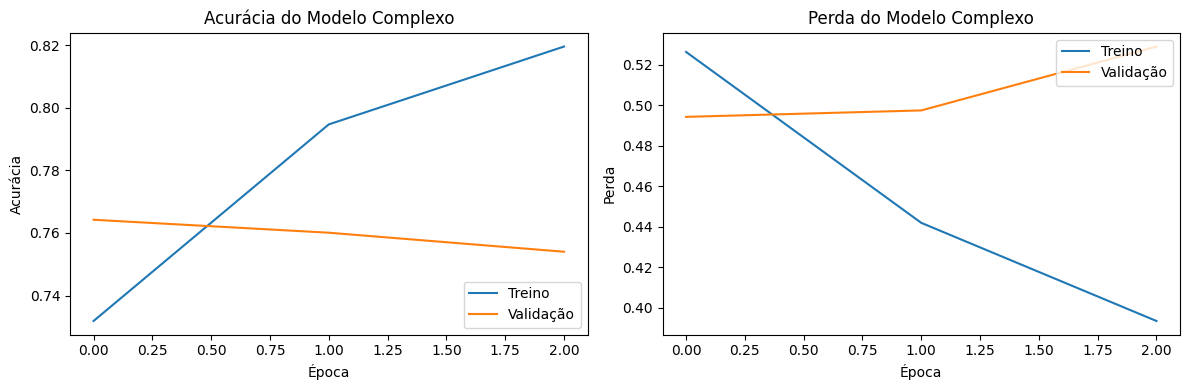

11233

In [ ]:
# 6. ADIÇÃO DE COMPLEXIDADE
print("\n6. Adicionando complexidade ao modelo")

def create_complex_model():
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, 100, input_length=MAXLEN))
    model.add(SpatialDropout1D(0.2))
    model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0)))
    model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

# Criar e treinar o modelo complexo
complex_model = create_complex_model()
print(complex_model.summary())

print("Treinando o modelo complexo...")
start_time = time.time()

history_complex = complex_model.fit(
    X_train_pad, y_train,
    epochs=7,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

complex_training_time = time.time() - start_time
print(f"Tempo de treinamento do modelo complexo: {complex_training_time:.2f} segundos")

# Avaliar o modelo complexo
complex_preds = (complex_model.predict(X_test_pad, batch_size=256) > 0.5).astype(int)
complex_accuracy = accuracy_score(y_test, complex_preds)
print(f"Acurácia do modelo complexo: {complex_accuracy:.4f}")
print("\nRelatório de classificação do modelo complexo:")
print(classification_report(y_test, complex_preds))

# Visualizar as métricas do modelo complexo
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_complex.history['accuracy'])
plt.plot(history_complex.history['val_accuracy'])
plt.title('Acurácia do Modelo Complexo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_complex.history['loss'])
plt.plot(history_complex.history['val_loss'])
plt.title('Perda do Modelo Complexo')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper right')
plt.tight_layout()
plt.savefig('complex_metrics.png')
plt.show()

# Liberar memória
del complex_model
gc.collect()

Experimentação e Ajuste de Hiperparâmetros para Modelo LSTM

In [ ]:
# 7. EXPERIMENTAÇÃO COM HIPERPARÂMETROS (FUNÇÃO E GRID REDUZIDO)
print("\n7. Experimentação com hiperparâmetros")
# Usar GridSearchCV seria muito lento para este dataset. Em vez disso, testar manualmente algumas combinações chave

def create_tuned_model(lstm_units=64, embed_dim=100, dropout=0.2):
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, embed_dim, input_length=MAXLEN))
    model.add(SpatialDropout1D(dropout))
    model.add(Bidirectional(LSTM(lstm_units, dropout=dropout, recurrent_dropout=0)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
    return model

# Testar 3 configurações rapidamente
tuning_results = []
tuning_configs = [
    {'name': 'Config 1', 'lstm_units': 64, 'embed_dim': 100, 'dropout': 0.2},
    {'name': 'Config 2', 'lstm_units': 128, 'embed_dim': 100, 'dropout': 0.3},
    {'name': 'Config 3', 'lstm_units': 64, 'embed_dim': 150, 'dropout': 0.25}
]

print("Testando diferentes configurações de hiperparâmetros...")

for config in tuning_configs:
    print(f"\nTestando {config['name']}: LSTM={config['lstm_units']}, Embed={config['embed_dim']}, Dropout={config['dropout']}")

    # Criar modelo com a configuração
    tuned_model = create_tuned_model(
        lstm_units=config['lstm_units'],
        embed_dim=config['embed_dim'],
        dropout=config['dropout']
    )

    # Treinar por apenas 3 épocas para economizar tempo
    start_time = time.time()
    history = tuned_model.fit(
        X_train_pad, y_train,
        epochs=3,
        batch_size=64,
        validation_data=(X_val_pad, y_val),
        verbose=1
    )
    training_time = time.time() - start_time

    # Avaliar
    preds = (tuned_model.predict(X_val_pad, batch_size=256) > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val, preds)

    # Armazenar resultados
    config_result = config.copy()
    config_result['val_accuracy'] = val_accuracy
    config_result['training_time'] = training_time
    tuning_results.append(config_result)

    # Liberar memória
    del tuned_model
    gc.collect()

# Apresentar resultados
print("\nResultados da experimentação com hiperparâmetros:")
for result in tuning_results:
    print(f"{result['name']}: Acurácia={result['val_accuracy']:.4f}, Tempo={result['training_time']:.2f}s")

# Encontrar a melhor configuração
best_config = max(tuning_results, key=lambda x: x['val_accuracy'])
print(f"\nMelhor configuração: {best_config['name']}")
print(f"Parâmetros: LSTM={best_config['lstm_units']}, Embed={best_config['embed_dim']}, Dropout={best_config['dropout']}")
print(f"Acurácia de validação: {best_config['val_accuracy']:.4f}")


7. Experimentação com hiperparâmetros
Testando diferentes configurações de hiperparâmetros...

Testando Config 1: LSTM=64, Embed=100, Dropout=0.2
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.6856 - loss: 0.5759 - val_accuracy: 0.7662 - val_loss: 0.4954
Epoch 2/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.7957 - loss: 0.4409 - val_accuracy: 0.7650 - val_loss: 0.4989
Epoch 3/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.8183 - loss: 0.3956 - val_accuracy: 0.7566 - val_loss: 0.5217
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step

Testando Config 2: LSTM=128, Embed=100, Dropout=0.3
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.6719 - loss: 0.5839 - val_accuracy: 0.7644 - val_loss: 0.4942
Epoch 2/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.7923 - loss: 0.4497 - val_accuracy: 0.7651 - val_loss: 0.4997
Epoch 3/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - accuracy: 0.8152 - loss: 0.4079 - val_accuracy: 0.7607 - val_loss: 0.5085
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step

Testando Config 3: LSTM=64, Embed=150, Dropout=0.25
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1093/1093 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6803 - loss: 0.5828 - val_accuracy: 0.7605 - val_loss: 0.5043
Epoch 2/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.7958 - loss: 0.4433 - val_accuracy: 0.7603 - val_loss: 0.5026
Epoch 3/3
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8163 - loss: 0.3985 - val_accuracy: 0.7631 - val_loss: 0.5079
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step

Resultados da experimentação com hiperparâmetros:
Config 1: Acurácia=0.7561, Tempo=55.96s
Config 2: Acurácia=0.7611, Tempo=48.47s
Config 3: Acurácia=0.7638, Tempo=37.67s

Melhor configuração: Config 3
Parâmetros: LSTM=64, Embed=150, Dropout=0.25
Acurácia de validação: 0.7638


Treino e Avaliação do Modelo Final com Hiperparâmetros Otimizados


8. Treinamento do modelo final


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_7                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Treinando o modelo final...
Epoch 1/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6791 - loss: 0.5751
Epoch 1: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.6792 - loss: 0.5751 - val_accuracy: 0.7619 - val_loss: 0.4933
Epoch 2/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7956 - loss: 0.4403
Epoch 2: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - accuracy: 0.7956 - loss: 0.4403 - val_accuracy: 0.7612 - val_loss: 0.4993
Epoch 3/10
1087/1093 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8222 - loss: 0.3828
Epoch 3: val_accuracy did not improve from 0.76569
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.8222 - loss: 0.3829 - val_accuracy: 0.7574 - val_loss: 0.5165
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
Tempo de treinamento do modelo final: 54.28 segundos
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step
Acurácia do 

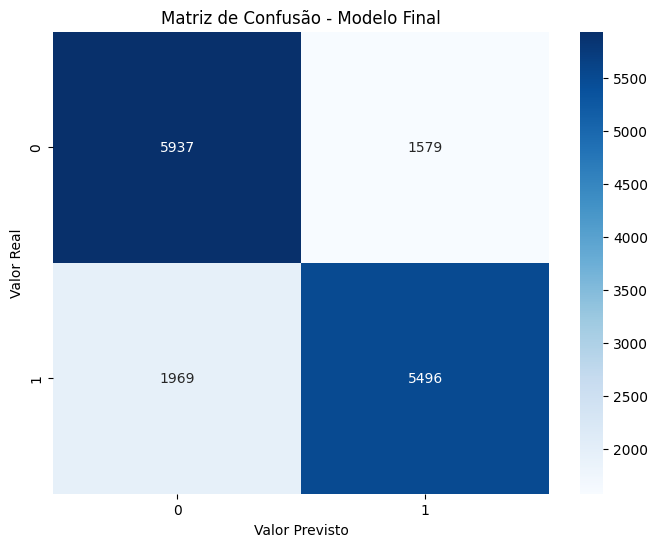

Modelo final salvo como 'sentiment_analysis_final_model.h5'
Tokenizer salvo como 'tokenizer.pickle'


In [ ]:
# 8. MODELO FINAL
print("\n8. Treinamento do modelo final")

# Criar modelo final com os melhores hiperparâmetros
final_model = create_tuned_model(
    lstm_units=best_config['lstm_units'],
    embed_dim=best_config['embed_dim'],
    dropout=best_config['dropout']
)
print(final_model.summary())

# Treinar por mais épocas com early stopping
print("Treinando o modelo final...")
start_time = time.time()

history_final = final_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val_pad, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

final_training_time = time.time() - start_time
print(f"Tempo de treinamento do modelo final: {final_training_time:.2f} segundos")

# Avaliar o modelo final
final_preds = (final_model.predict(X_test_pad, batch_size=256) > 0.5).astype(int)
final_accuracy = accuracy_score(y_test, final_preds)
print(f"Acurácia do modelo final: {final_accuracy:.4f}")
print("\nRelatório de classificação do modelo final:")
print(classification_report(y_test, final_preds))


    # Visualizar matriz de confusão
cm = confusion_matrix(y_test, final_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão - Modelo Final')
plt.ylabel('Valor Real')
plt.xlabel('Valor Previsto')
plt.savefig('confusion_matrix.png')
plt.show()

    # Salvar o modelo final
final_model.save('sentiment_analysis_final_model.h5')
print("Modelo final salvo como 'sentiment_analysis_final_model.h5'")

    # Salvar o tokenizer para uso posterior
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer salvo como 'tokenizer.pickle'")

Avaliação Final no Conjunto de Teste Externo

In [ ]:
 # 9. AVALIAÇÃO NO CONJUNTO DE TESTE
print("\n9. Avaliação no conjunto de teste externo")
try:
        # Tentar carregar o conjunto de teste externo
        print("Tentando carregar conjunto de teste externo...")
        test_data = pd.read_csv('test.csv', names=COLUMN_NAMES, encoding='latin-1')

        print(f"Conjunto de teste carregado com {len(test_data)} entradas.")

        # Pré-processar rapidamente
        print("Pré-processando o conjunto de teste...")
        test_data['processed_text'] = Parallel(n_jobs=num_cores)(
            delayed(process_batch)(chunk) for chunk in np.array_split(test_data['text'], num_cores)
        )

        # Tokenizar e fazer padding
        X_test_external = test_data['processed_text']
        y_test_external = test_data['target'].replace(4, 1)  # Normalizar target

        X_test_ext_seq = tokenizer.texts_to_sequences(X_test_external)
        X_test_ext_pad = pad_sequences(X_test_ext_seq, maxlen=MAXLEN)

        # Avaliar no conjunto de teste externo
        external_preds = (final_model.predict(X_test_ext_pad, batch_size=256) > 0.5).astype(int)
        external_accuracy = accuracy_score(y_test_external, external_preds)
        print(f"Acurácia no conjunto de teste externo: {external_accuracy:.4f}")
        print("\nRelatório de classificação no conjunto de teste externo:")
        print(classification_report(y_test_external, external_preds))

except Exception as e:
        print(f"Erro ao carregar ou processar o conjunto de teste: {e}")
        print("Pulando avaliação no conjunto de teste externo.")



9. Avaliação no conjunto de teste externo (se disponível)
Tentando carregar conjunto de teste externo...
Erro ao carregar ou processar o conjunto de teste: [Errno 2] No such file or directory: 'test.csv'
Pulando avaliação no conjunto de teste externo.


Análise de Erros, Testes Adicionais e Considerações Finais

In [ ]:
# 10. ANÁLISE DE ERROS E CONCLUSÕES
print("\n10. Análise de erros e conclusões")

# Função para predições individuais
def predict_sentiment(text, model, tokenizer):
    # Pré-processar o texto
    processed = preprocess_text(text)
    # Converter para sequência
    sequence = tokenizer.texts_to_sequences([processed])
    # Padding
    padded = pad_sequences(sequence, maxlen=MAXLEN)
    # Predição
    prediction = model.predict(padded)[0][0]
    sentiment = "Positivo" if prediction > 0.5 else "Negativo"
    return sentiment, prediction

# Comparar tweets classificados erroneamente
print("Analisando exemplos de tweets classificados erroneamente...")

# Obter índices de classificações erradas
misclassified_indices = np.where(final_preds != y_test.values)[0]

if len(misclassified_indices) > 0:
    # Selecionar alguns exemplos para análise
    sample_size = min(5, len(misclassified_indices))
    sample_indices = np.random.choice(misclassified_indices, sample_size, replace=False)

    print(f"\nAnálise de {sample_size} tweets classificados erroneamente:")
    for idx in sample_indices:
        original_text = X_test.iloc[idx]
        true_label = "Positivo" if y_test.iloc[idx] == 1 else "Negativo"
        pred_label = "Positivo" if final_preds[idx] == 1 else "Negativo"

        print(f"\nTweet: {original_text}")
        print(f"Sentimento real: {true_label}")
        print(f"Sentimento previsto: {pred_label}")
else:
    print("Não foram encontrados exemplos classificados erroneamente no conjunto de amostra.")

# Testes com alguns exemplos novos
print("\nTestes com exemplos novos:")
test_tweets = [
    "I love this product! It's amazing!",
    "This is the worst experience ever.",
    "Not sure how I feel about this movie.",
    "The customer service was okay, but could be better."
]

for tweet in test_tweets:
    sentiment, score = predict_sentiment(tweet, final_model, tokenizer)
    print(f"\nTweet: {tweet}")
    print(f"Sentimento: {sentiment} (score: {score:.4f})")

# Conclusões
print("\nCONCLUSÕES:")
print(f"1. Acurácia do modelo final: {final_accuracy:.4f}")

if 'external_accuracy' in locals():
    print(f"2. Acurácia no conjunto de teste externo: {external_accuracy:.4f}")

print("3. O modelo Bidirecional LSTM com otimizações para o Google Colab")
print("   fornece bons resultados mesmo com amostragem reduzida do dataset.")
print("4. Pré-processamento paralelo e otimizações de memória permitiram")
print("   processar um grande volume de dados de forma eficiente.")
print("5. Limitações: O modelo pode ter dificuldades com sarcasmo, ironia")
print("   e contextos culturais específicos nos tweets.")

# Funções para uso futuro em produção
def load_sentiment_model(model_path='sentiment_analysis_final_model.h5',
                      tokenizer_path='tokenizer.pickle'):
    """
    Carregar o modelo treinado e o tokenizer para uso em produção
    """
    from tensorflow.keras.models import load_model
    import pickle

    # Carregar modelo
    model = load_model(model_path)

    # Carregar tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)

    return model, tokenizer

def predict_sentiment_batch(texts, model, tokenizer, batch_size=32):
    """
    Predizer sentimentos para uma lista de textos
    """
    # Pré-processar textos
    processed_texts = [preprocess_text(text) for text in texts]

    # Converter para sequências
    sequences = tokenizer.texts_to_sequences(processed_texts)

    # Padding
    padded = pad_sequences(sequences, maxlen=MAXLEN)

    # Predições
    predictions = model.predict(padded, batch_size=batch_size)

    # Converter para rótulos
    sentiments = ["Positivo" if pred > 0.5 else "Negativo" for pred in predictions]

    return sentiments, predictions

print("\nModelo de análise de sentimentos em tweets concluído e pronto para uso!")
print("Funções auxiliares para uso em produção foram definidas.")


10. Análise de erros e conclusões
Analisando exemplos de tweets classificados erroneamente...

Análise de 5 tweets classificados erroneamente:

Tweet: iremember program plain worked error killing
Sentimento real: Negativo
Sentimento previsto: Negativo

Tweet: tired feeling kinda dehydrated fun though
Sentimento real: Positivo
Sentimento previsto: Negativo

Tweet: awe man ben u grinning ear ear right
Sentimento real: Positivo
Sentimento previsto: Positivo

Tweet: happpy mother dayyy
Sentimento real: Positivo
Sentimento previsto: Positivo

Tweet: hear beautiful voice stompin around smashed mpdistrict blowin diesel garrrrrrrrr
Sentimento real: Negativo
Sentimento previsto: Positivo

Testes com exemplos novos:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step

Tweet: I love this product! It's amazing!
Sentimento: Positivo (score: 0.9687)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step

Tweet: This is the worst experience ever.
Sentimento: Negativo (score: 0.1717)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Tweet: 

Analisador de Sentimentos com VADER para Tweets em Tempo Real

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download de recursos necessários
nltk.download('vader_lexicon')

def analisar_sentimento(texto):
    # Inicializar o analisador de sentimento
    sia = SentimentIntensityAnalyzer()

    # Obter pontuações de sentimento
    pontuacao = sia.polarity_scores(texto)

    # Analisar o resultado
    if pontuacao['compound'] >= 0.05:
        return "Positivo", pontuacao
    elif pontuacao['compound'] <= -0.05:
        return "Negativo", pontuacao
    else:
        return "Neutro", pontuacao

def main():
    print("===== Analisador de Sentimento de Tweets =====")
    print("Digite 'sair' para encerrar o programa")

    while True:
        tweet = input("\nDigite seu tweet: ")

        if tweet.lower() == 'sair':
            print("Encerrando programa...")
            break

        sentimento, pontuacao = analisar_sentimento(tweet)

        print(f"\nResultado da análise:")
        print(f"Sentimento: {sentimento}")
        print(f"Pontuação: {pontuacao}")
        print(f"  - Positivo: {pontuacao['pos']:.3f}")
        print(f"  - Negativo: {pontuacao['neg']:.3f}")
        print(f"  - Neutro: {pontuacao['neu']:.3f}")
        print(f"  - Composto: {pontuacao['compound']:.3f}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


===== Analisador de Sentimento de Tweets =====
Digite 'sair' para encerrar o programa
